In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd


In [2]:
from model_prep import get_feature_name, model_transformer_train

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

(<Scheduler: "tcp://127.0.0.1:59783" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:59806, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:59803, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:59800, threads: 2>})

In [5]:
model_data = pd.read_pickle('Data/model_data.pkl')

In [6]:
model_data.columns

Index(['id', 'class', 'amount_tsh', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'basin', 'subvillage', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'management', 'management_group', 'payment_type', 'water_quality',
       'quantity', 'source', 'waterpoint_type', 'water_quality_rank',
       'quantity_rank', 'quant_qual_rank', 'subvillage_rank', 'urban_rural',
       'ward_rank', 'year', 'month', 'years_old', 'fund_inst_same', 'pay_rank',
       'popbins', 'tsh_rank'],
      dtype='object')

In [7]:
model_data['class'] = model_data['class'].map({'functional':2, 'non functional':0, 'functional needs repair':1})
id_col = model_data['id']
model_data.drop(columns=['id'], inplace=True)

In [8]:
num_cols = ['gps_height', 'population', 'amount_tsh']
cat_cols = ['basin', 'region_code', 'district_code', 
            'extraction_type', 'payment_type', 'water_quality', 'quantity', 
            'source', 'management', 'management_group', 'waterpoint_type',  'funder', 'installer', 'subvillage', 
            'ward', 'scheme_management', 'scheme_name', 'popbins', 'lga', 'urban_rural', 'tsh_rank', ]

In [9]:
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')
CT = ColumnTransformer(remainder='passthrough', transformers=[('scaler', scaler, num_cols),
                                              ('ohe', ohe, cat_cols)], verbose=True, sparse_threshold=0)

In [10]:
def prep_train(unprepped_values, class_col):
    train_X, test_X, train_y, test_y = train_test_split(unprepped_values.drop(columns=[class_col]), 
                                                        unprepped_values[class_col], test_size=0.25, random_state=42)
    train_Xct = CT.fit_transform(train_X)
    
    test_Xct = CT.transform(test_X)

    cols = get_feature_name(CT)
    train_Xf = pd.DataFrame(train_Xct, columns=cols)
    cols = get_feature_name(CT)
    test_Xf = pd.DataFrame(test_Xct, columns=cols)
    
    return train_Xf, train_y, test_Xf, test_y   

In [11]:
def prep_submit(unprepped_values):
    submit_X= unprepped_values
        
    submit_Xt = model_transformer_train(submit_X)
    submit_Xct = CT.transform(submit_Xt)

    cols = get_feature_name(CT)
    submit_Xf = pd.DataFrame(submit_Xct.todense(), columns=cols)
    
    return submit_Xf

In [13]:
train_X, train_y, test_X, test_y = prep_train(model_data, 'class')#.drop(columns=['quantity', 'water_quality']), 'class')

[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.4s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   25.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8054545454545454


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.1s finished


<Figure size 2880x576 with 0 Axes>

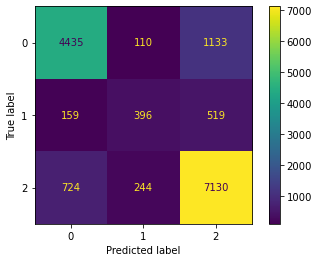

In [14]:
rf_clean = RandomForestClassifier(n_estimators=250, verbose=True, class_weight='balanced_subsample')
with joblib.parallel_backend('dask'):
    rf_clean.fit(train_X, train_y)
print(rf_clean.score(test_X, test_y))
y_pred = rf_clean.predict(test_X)
with joblib.parallel_backend('dask'):
    cm=confusion_matrix(test_y, y_pred, labels=rf_clean.classes_)
    disp = ConfusionMatrixDisplay(cm, display_labels=rf_clean.classes_)
plt.figure(figsize=(40,8))
disp.plot()

In [15]:
pd.DataFrame(rf_clean.feature_importances_.reshape(1,-1), columns=train_X.columns, index=['importance']).T.sort_values(by='importance', ascending=False).head(30)

,importance
longitude,0.085345
latitude,0.080733
scaler__gps_height,0.074461
years_old,0.040214
quantity_rank,0.037657
subvillage_rank,0.031750
scaler__population,0.030765
quant_qual_rank,0.027482
ohe__x6_dry,0.022590
ward_rank,0.021677


In [16]:
print(cross_val_score(rf_clean, train_X, train_y))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   46.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   45.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   45.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[0.81043771 0.80280584 0.80179574 0.80190797 0.7996633 ]


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished
